<a href="https://colab.research.google.com/github/ayushpatra11/CV_CW/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opencv-python numpy scikit-learn matplotlib

In [2]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def resize_images(images, target_size=(128, 128)):
  return np.array([cv.resize(img, target_size) for img in images])

x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)

x_train_resized = x_train_resized[:5000]
x_test_resized = x_test_resized[:200]
y_train = y_train[:5000].flatten()
y_test = y_test[:200].flatten()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
orb = cv.ORB_create(nfeatures=200)
descriptors_list = []

for img in x_train_resized:
  kp, des = orb.detectAndCompute(cv.cvtColor(img, cv.COLOR_RGB2GRAY), None)
  if des is not None:
    descriptors_list.append(des)

all_desc = np.vstack(descriptors_list)
print("Descriptor shape:", all_desc.shape)
k=200
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_desc)

Descriptor shape: (92756, 32)


KMeans(n_clusters=200)

In [4]:
def compute_bow_histogram(image, kmeans, orb):
    kp, des = orb.detectAndCompute(cv.cvtColor(image, cv.COLOR_RGB2GRAY), None)
    if des is None:
        return np.zeros(k)
    cluster_result = kmeans.predict(des)
    hist, _ = np.histogram(cluster_result, bins=np.arange(k + 1))
    return hist

X_train_bow = np.array([compute_bow_histogram(img, kmeans, orb) for img in x_train_resized])
X_test_bow = np.array([compute_bow_histogram(img, kmeans, orb) for img in x_test_resized])

In [5]:
svm = SVC(kernel='linear')
svm.fit(X_train_bow, y_train)
y_pred = svm.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.18
              precision    recall  f1-score   support

           0       0.12      0.15      0.13        20
           1       0.17      0.21      0.19        14
           2       0.14      0.24      0.18        21
           3       0.20      0.11      0.14        19
           4       0.07      0.13      0.09        15
           5       0.07      0.06      0.06        18
           6       0.33      0.27      0.30        26
           7       0.36      0.22      0.28        18
           8       0.36      0.14      0.21        28
           9       0.22      0.24      0.23        21

    accuracy                           0.18       200
   macro avg       0.20      0.18      0.18       200
weighted avg       0.22      0.18      0.19       200



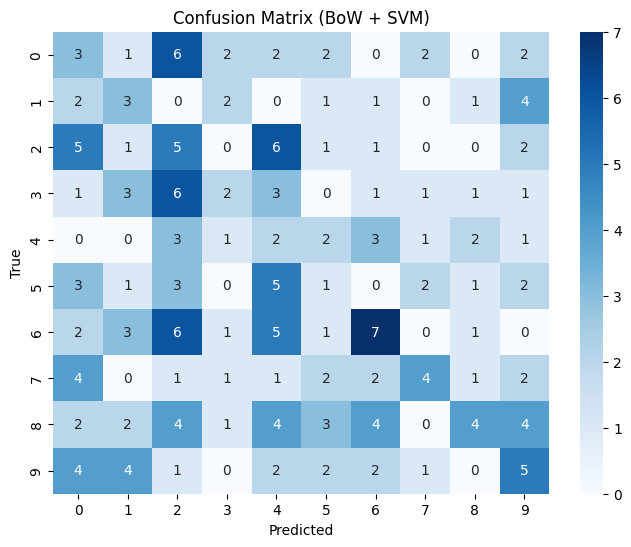

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title("Confusion Matrix (BoW + SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

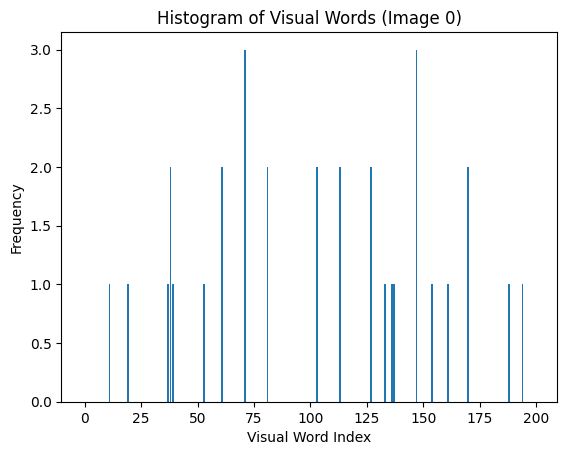

In [7]:
# For a single image:
idx = 0
hist = compute_bow_histogram(x_train_resized[idx], kmeans, orb)

plt.bar(range(len(hist)), hist)
plt.title(f"Histogram of Visual Words (Image {idx})")
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.show()

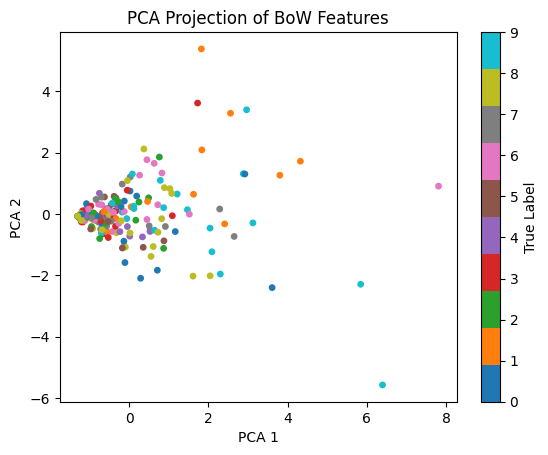

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_test_bow)

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_test, cmap='tab10', s=15)
plt.title("PCA Projection of BoW Features")
plt.colorbar(label="True Label")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

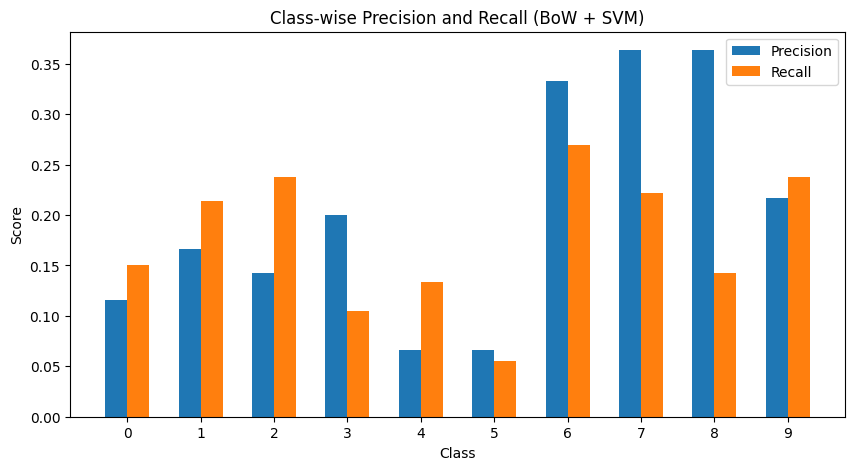

In [9]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

classes = [str(i) for i in range(10)]
x = range(len(classes))

plt.figure(figsize=(10, 5))
plt.bar(x, precision, width=0.3, label='Precision', align='center')
plt.bar([i + 0.3 for i in x], recall, width=0.3, label='Recall', align='center')
plt.xticks([i + 0.15 for i in x], classes)
plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Class-wise Precision and Recall (BoW + SVM)")
plt.legend()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [11]:
transform = transforms.Compose([
    transforms.Resize(224),  # VGG16 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


In [13]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

# Freeze feature layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace classifier for CIFAR-10 (10 classes)
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

vgg16 = vgg16.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 39.9MB/s]


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

In [ ]:
num_epochs = 10
train_acc_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0
    vgg16.train()

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    train_acc_list.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.3f}, Accuracy: {acc:.4f}")

In [ ]:
vgg16.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - VGG16')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()